# Pulsar Timing Analysis

Welcome to our step-by-step Jupyter notebook tutorial on pulsar timing analysis using the TAT-Pulsar Python package.

Throughout this guide, we'll provide you with hands-on examples of how to use the key features of TAT-Pulsar. 

## Search the best frequency

In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import wget, os
from astropy.io import fits

mpl.rcParams['figure.dpi'] = 250
plt.style.use(['science', 'nature', 'no-latex'])

In [2]:
test_data_url = "https://zenodo.org/record/6785435/files/NICER_Crab_data.gz?download=1"
test_orbit_url = "https://zenodo.org/record/6785435/files/NICER_Crab_orb.gz?download=1"
# The real data are Crab data observed by NICER. 
# The size of event file is 170MB.

test_file = "NICER_Crab_data.gz"
orbit_file = "NICER_Crab_orb.gz"
if not os.path.exists(test_file):
    print("Downloading the test datab")
    wget.download(test_data_url)
    wget.download(test_orbit_url)
else:
    print(f"The test data '{test_file}' is already downloaded!")    

The test data 'NICER_Crab_data.gz' is already downloaded!


## Bayrcentric correction

Read the events data from FITS file

In [3]:
hdulist = fits.open(test_file)
time = hdulist['EVENTS'].data['TIME']
time = time + hdulist['EVENTS'].header['TIMEZERO'] # NICER Time system correction

Retrieve the parameters from Jodrell Bank Crab monitoring website: http://www.jb.man.ac.uk/~pulsar/crab/all.gro 

Then write the parameter table into a local file 'Crab.gro', and get the Crab timing parameters covering the observed data.

In [4]:
from tatpulsar.pulse.Crab.retrive_eph import retrieve_ephemeris, get_par
from tatpulsar.utils.functions import met2mjd

eph = retrieve_ephemeris(write_to_file=True, ephfile='Crab.gro')
par = get_par( met2mjd(time[0], telescope='nicer'), eph)
print(par)

/Users/tuoyouli/anaconda3/lib/python3.7/site-packages/numba/core/decorators.py:255: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)


PSR_B       0531+21
RA_hh             5
RA_mm            34
RA_ss        31.972
DEC_hh           22
DEC_mm            0
DEC_ss        52.07
MJD1          57966
MJD2          57997
t0geo       57981.0
f0        29.639378
f1             -0.0
f2              0.0
RMS             0.6
O                 J
B             DE200
name        0531+21
Notes           NaN
Name: 374, dtype: object


----------
According to the GRO parameter provided by Jodrell Bank, the reference time of timing parameters is the integer part of the `t0geo`, `t0geo` is the time of arrival of radio pulse measured at the geometric center of the Earth (in UTC time system). So We convert the `t0geo` to the barycenter of the solar system and calculate the phase of it as `phi0` (convert UTC to TT first).

If we want to compare the absolute phase and the phase lag of the profile with the radio (and we usually compare the phase main peak with the Jodrell Bank main peak), we shift the profiles with `phi0`, and it appears to locate near the phase one.


In [5]:
from tatpulsar.pulse.barycor.barycor import barycor
from tatpulsar.pulse.fold import cal_phase
from astropy.time import Time

# barycentric correction on t0geo
t0tt = Time(par.t0geo, format='mjd', scale='utc').tt.to_value(format='mjd')
t0bary = barycor(t0tt, ra=83.63321666666667, dec=22.01446388888889)

phi0 = cal_phase(t0bary, pepoch=int(par.t0geo),
                 f0=par.f0, f1=par.f1, f2=par.f2,
                format='mjd')

print(f"the main peak of radio pulse is {phi0}.")

the main peak of radio pulse is 0.7807356869125215.


Now we calculate the barycentric correction on each photon.

In [6]:
# barycor only support time in MJD
from tatpulsar.utils.functions import met2mjd, mjd2met

time_mjd = met2mjd(time, telescope='nicer')
tdb_mjd = barycor(time_mjd, ra=83.63321666666667, dec=22.01446388888889,
              orbit=orbit_file, accelerate=True)

# convert the TDB in MJD into MET system
tdb = mjd2met(tdb_mjd, telescope='nicer')

Accelerating barycor


Now we calculate the phase for each photon, and fold the profile, using the function `tatpulsar.pulse.fold.fold`.

Text(0, 0.5, 'Counts')

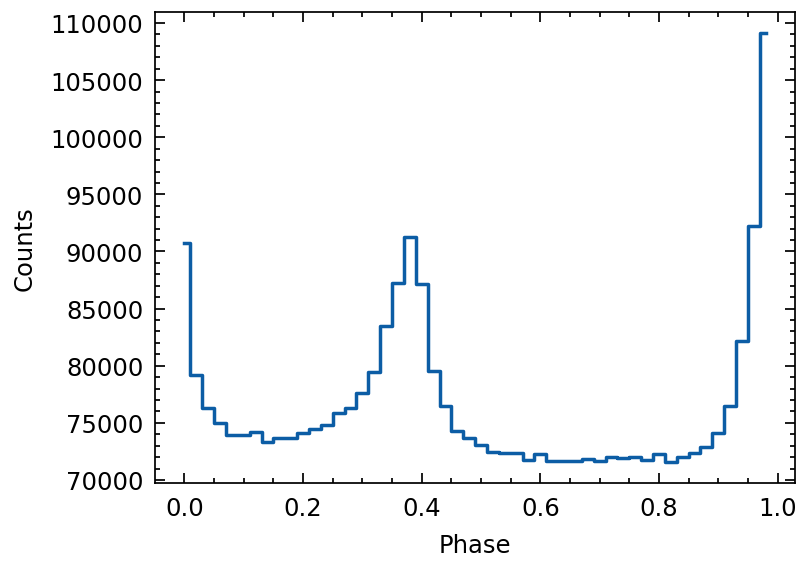

In [7]:
from tatpulsar.pulse.fold import fold
from tatpulsar.data.profile import Profile

profile = fold(tdb, f0=par.f0, f1=par.f1, f2=par.f2,
                   pepoch=mjd2met(int(par.t0geo), telescope='nicer'),
                   nbins=50, phi0=phi0)

plt.errorbar(profile.phase, profile.counts, ds='steps-mid')
plt.xlabel("Phase")
plt.ylabel("Counts")

## Play with the profile

Text(0, 0.5, 'Counts')

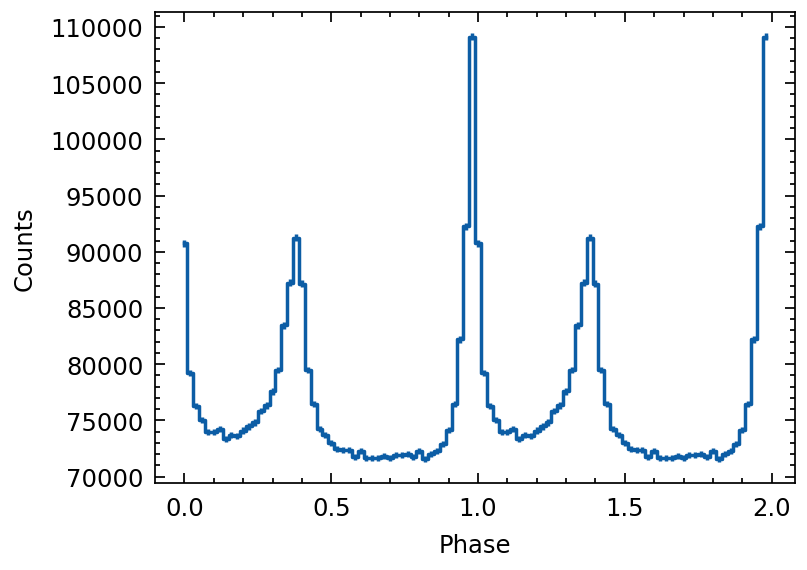

In [8]:
profile.cycles = 2 # set the phase cycls of profile
plt.errorbar(profile.phase,
             profile.counts,
             yerr=profile.error,
             ds='steps-mid')
plt.xlabel("Phase")
plt.ylabel("Counts")

Text(0, 0.5, 'numbers of profiles')

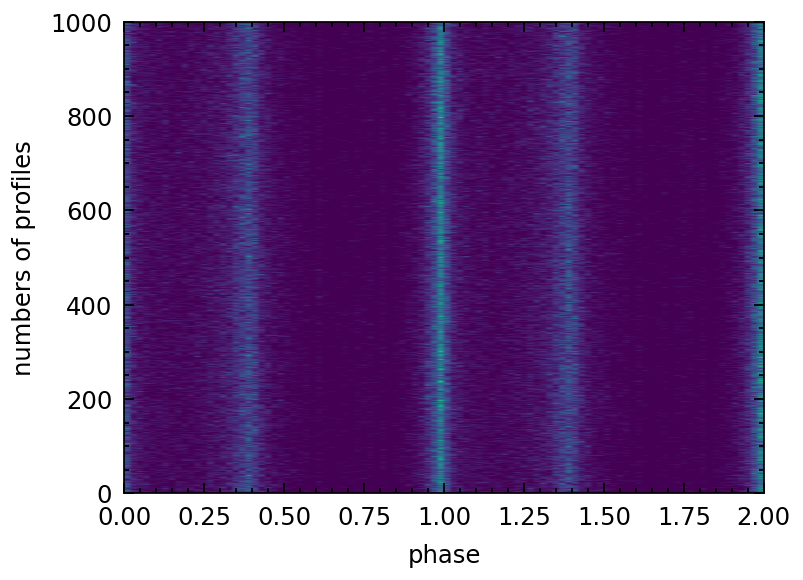

In [20]:
profile.norm(method=1) # Normalization
profile_new = profile.resample(sample_num=1000)

plt.imshow(profile_new, aspect='auto',
           extent=[0,2,0, 1000])
plt.xlabel("phase")
plt.ylabel("numbers of profiles")